# Extraer datos de: [Dataset](https://ookla-open-data.s3-us-west-2.amazonaws.com/shapefiles/performance/type%3Dfixed/year%3D2019/quarter%3D1/2019-01-01_performance_fixed_tiles.zip) y filtrarlos únicamente para Bolivia
Nota: Se recomienda usar los archivos tipo .shp directamente (`/shapefiles/performance` no `/performance`) y no como se muestra a continuación desde el .parquet. Este notebook queda únicamente como muestra de cómo se puede hacer la manipulación y conversión de este tipo de archivos y datos presentes.  
### Ref: [Speedtest by Ookla Global Fixed and Mobile Network Performance Maps](https://registry.opendata.aws/speedtest-global-performance/)

In [69]:
import pandas as pd
from shapely.geometry import Polygon, Point
import matplotlib.pyplot as plt
import shapely.wkt
import geopandas as gpd

In [2]:
df = pd.read_parquet('performance/type=fixed/year=2019/quarter=1/2019-01-01_performance_fixed_tiles.parquet', engine='pyarrow')

In [3]:
df.head()

,quadkey,tile,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices
0,0022133222312322,"POLYGON((-160.02685546875 70.6435894914449, -1...",8763,3646,45,1,1
1,0022133222330013,"POLYGON((-160.032348632812 70.6399478155463, -...",9195,3347,43,1,1
2,0022133222330023,"POLYGON((-160.043334960938 70.6363054807905, -...",6833,3788,42,1,1
3,0022133222330100,"POLYGON((-160.02685546875 70.6417687358462, -1...",8895,3429,43,2,2
4,0022320121121332,"POLYGON((-166.739501953125 68.3526207780586, -...",4877,935,45,3,2


In [4]:
p1 = df['tile'][0]
p1

'POLYGON((-160.02685546875 70.6435894914449, -160.021362304688 70.6435894914449, -160.021362304688 70.6417687358462, -160.02685546875 70.6417687358462, -160.02685546875 70.6435894914449))'

## Leemos las coordenadas del polígono que forma Bolivia (http://boundaries.us/country/bo/)
Nota: La latitud (expresada como Y) proporciona la localización de un lugar en dirección Norte o Sur desde el ecuador mientras que la longitud (expresada com X) proporciona la localización de un lugar en dirección Este u Oeste desde el meridiano de Greenwich.

In [5]:
df_bol = pd.read_csv('../bo.csv')

In [6]:
df_bol.head()

,lat,long
0,-22.09473,-65.19020
1,-22.10000,-65.59889
2,-22.10889,-65.65750
3,-22.11334,-65.73418
4,-22.11167,-65.74806


In [7]:
# Generamos un Polígono con las coordenadas que mapean a Bolivia
bolivia_coor = [(long, lat) for lat, long in zip(df_bol['lat'], df_bol['long'])]

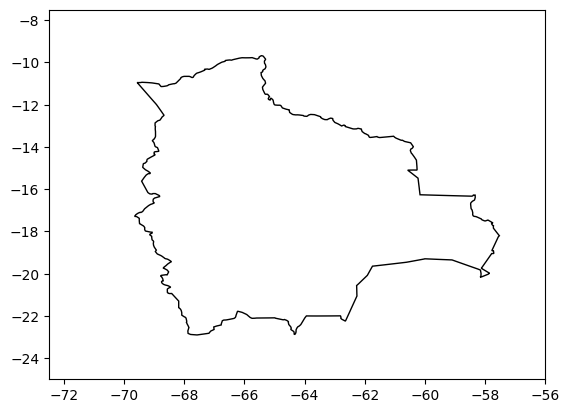

In [8]:
polygon = plt.Polygon(bolivia_coor, closed=True, fill=None)

# Creamos el plot y agregamos el polígono
_, ax = plt.subplots()
ax.add_patch(polygon)

# Configuramos los límites del gráfico
ax.set_xlim(-72.5, -56)
ax.set_ylim(-25, -7.5)

plt.show()

## Procedemos a filtrar las coordenadas del dataset origen con aquellos polígonos en donde su área caiga dentro de nuestro polígono de Bolivia

In [85]:
bolivia_coor[:5]

[(-65.1902, -22.09473),
 (-65.59889, -22.1),
 (-65.6575, -22.10889),
 (-65.73418, -22.11334),
 (-65.74806, -22.11167)]

In [58]:
# Generamos un polígono de Bolivia
bolivia_polygon = Polygon(bolivia_coor)

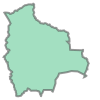

In [59]:
bolivia_polygon

In [11]:
# Convertimos los strings de la columna tile a tipo Polygon
df['tile'] = [shapely.wkt.loads(polygon) for polygon in df['tile']]

In [60]:
# Función para extraer una lista de puntos de un polígono
def extract_points(polygon):
    cx = polygon.exterior.coords.xy[0]
    cy = polygon.exterior.coords.xy[1]
    return [Point(x, y) for x,y in zip(cx, cy)]

In [50]:
# Verificamos si un punto del polígono cae dentro de nuestro polígono de Bolivia
# record_index = []
# for i, polygon in enumerate(df['tile']):
#     points = extract_points(polygon)
#     for p in points:
#         if bolivia_polygon.contains(p):
#             record_index.append(i)
#             break

In [54]:
# Recuperamos todos los índices de los records que pertenecen a Bolivia
bolivian_records = [i for i, polygon in enumerate(df['tile']) if polygon.within(bolivia_polygon)]

In [61]:
print(f'Se lograron identificar {len(bolivian_records)} records que pertenecen a Bolivia')

Se lograron identificar 2667 records que pertenecen a Bolivia


In [65]:
bolivian_df = df.iloc[bolivian_records]

In [66]:
bolivian_df.head()

,quadkey,tile,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices
4481982,2100133333331200,"POLYGON ((-67.5439453125 -11.1137272821727, -6...",671,9679,71,1,1
4485379,2100313113311001,"POLYGON ((-67.5384521484375 -14.4346802152973,...",14919,11459,46,78,2
4485380,2100313113311012,"POLYGON ((-67.532958984375 -14.4399999100842, ...",19376,9636,24,8,1
4485485,2100313210303133,"POLYGON ((-69.3511962890625 -15.5119122493399,...",12487,315,45,2,1
4485486,2100313213010333,"POLYGON ((-69.1314697265625 -15.6600649920673,...",2531,1663,50,1,1


In [71]:
bolivian_df.rename(columns={"tile": "geometry"})

,quadkey,geometry,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices
4481982,2100133333331200,"POLYGON ((-67.5439453125 -11.1137272821727, -6...",671,9679,71,1,1
4485379,2100313113311001,"POLYGON ((-67.5384521484375 -14.4346802152973,...",14919,11459,46,78,2
4485380,2100313113311012,"POLYGON ((-67.532958984375 -14.4399999100842, ...",19376,9636,24,8,1
4485485,2100313210303133,"POLYGON ((-69.3511962890625 -15.5119122493399,...",12487,315,45,2,1
4485486,2100313213010333,"POLYGON ((-69.1314697265625 -15.6600649920673,...",2531,1663,50,1,1
...,...,...,...,...,...,...,...
4543775,2103001010111113,"POLYGON ((-63.6383056640625 -21.9481406581903,...",16397,52176,25,1,1
4543799,2103001020133123,"POLYGON ((-64.3524169921875 -22.7305904254938,...",204,79,140,1,1
4543800,2103001020133130,"POLYGON ((-64.346923828125 -22.7255238110894, ...",9669,5787,73,2,2
4543801,2103001020133132,"POLYGON ((-64.346923828125 -22.7305904254938, ...",11340,6401,67,12,4


In [73]:
# Convertimos el dataframe a un geopandas geodataframe
gdf = gpd.GeoDataFrame(bolivian_df, geometry='geometry')

# Guardamos el geodataframe como tipo shapefile
gdf.to_file("bolivia_shape/bolivia_inter.shp", driver="ESRI Shapefile")

In [67]:
# Exportamos el nuevo dataset únicamente con los datos de Bolivia
# bolivian_df.to_csv("bolivia_internet.csv")